Load, Validate, and Split the Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv('movies_comments_cleanTest_with_sentimate.csv', encoding='utf-8', on_bad_lines='skip',  engine='python')

# Define valid columns
valid_columns = [f'comment_sentiment_{i}' for i in range(1, 101)]

# Drop invalid rows(rows that dont have values in all the comment sentiment columns)
df_valid = df.dropna(subset=valid_columns).copy()

# Drop rows with over 43 columns of sentiment equal to 0
df_valid["zero_count"] = (df_valid[valid_columns] == 0).sum(axis=1)
df_valid_reduced = df_valid[df_valid["zero_count"] <= 43].drop("zero_count", axis=1)

# Ensure sentiment scores are numerical, if not they will become NaN
for col in valid_columns:
    df_valid_reduced[col] = pd.to_numeric(df_valid_reduced[col])

# Assign the sentiment columns to X, filling all NaN with 0
X = df_valid_reduced[valid_columns].fillna(0)

# Assign critics_score to y (remove '%' and convert to float)
y = pd.to_numeric(df_valid_reduced['critics_score'].str.rstrip('%'))

# Drop rows where y is NaN
X = X[~y.isna()]
y = y[~y.isna()]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Shape of X: (44, 100)
Shape of y: (44,)
Training set size: (35, 100)
Testing set size: (9, 100)


Train Regression Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Computes weights inversely proportional to the frequency of scores to balance skewed distribution
def compute_weights(critic_scores):
    bins = [0, 20, 40, 60, 80, 100]
    counts, _ = np.histogram(critic_scores, bins=bins)
    weights = 1 / np.sqrt(counts + 1e-6)
    bin_indices = np.digitize(critic_scores, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(weights) - 1)
    return weights[bin_indices]

# Initialize model with regularization
model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,          # Use 80% of the data per tree
    colsample_bytree=0.8,   # Use 80% of the features per tree
    reg_alpha=0.1,          # L1 regularization term
    reg_lambda=1.0,         # L2 regularization term
    random_state=42
)

#Train model with weights
model.fit(
    X_train,
    y_train,
    sample_weight=compute_weights(y_train)
)

# Evaluate model
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calculate percent accuracy within 10% in test set
percentage_difference_test = 100 * np.abs(y_pred - y_test) / y_test
accurate_within_10_percent_test = np.sum(percentage_difference_test <= 10)
accuracy_percentage_test = 100 * accurate_within_10_percent_test / len(y_test)
# Calculate percent accuracy within 5% in test set
accurate_within_5_percent_test = np.sum(percentage_difference_test <= 5)
accuracy_percentage_5_test = 100 * accurate_within_5_percent_test / len(y_test)

# Calculate percent accuracy within 10% in full dataset
y_pred_all = model.predict(X)
percentage_difference_test_all = 100 * np.abs(y_pred_all - y) / y
accurate_within_10_percent_test_all = np.sum(percentage_difference_test_all <= 10)
accuracy_percentage_test_all = 100 * accurate_within_10_percent_test_all / len(y)
# Calculate percent accuracy within 5% in full dataset
accurate_within_5_percent_test_all = np.sum(percentage_difference_test_all <= 5)
accuracy_percentage_5_test_all = 100 * accurate_within_5_percent_test_all / len(y)

# Print results
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}\n")
print(f"Percent accuracy within 10% in test set: {accuracy_percentage_test:.2f}%")
print(f"Percent accuracy within 10% in full dataset: {accuracy_percentage_test_all:.2f}%\n")
print(f"Percent accuracy within 5% in test set: {accuracy_percentage_5_test:.2f}%")
print(f"Percent accuracy within 5% in full dataset: {accuracy_percentage_5_test_all:.2f}%")

MAE: 11.586575826009115
RMSE: 15.875706226033193
R²: 0.13802218437194824

Percent accuracy within 10% in test set: 44.44%
Percent accuracy within 10% in full dataset: 88.64%

Percent accuracy within 5% in test set: 33.33%
Percent accuracy within 5% in full dataset: 86.36%


Store Predicted Scores in an SQL Database

In [ ]:
import sqlite3

conn = sqlite3.connect('movies_scores.db')
cursor = conn.cursor()

# Create table if it doesn't exist
cursor.execute('''
CREATE TABLE IF NOT EXISTS PredictedScores (
    MovieID INTEGER,
    Title TEXT,
    AudienceScore REAL,
    CriticScore REAL,
    PredictedScore REAL
)
''')

# Clear the table if it exists
cursor.execute('DELETE FROM PredictedScores')

for i, row in df_valid.iterrows():
    try:
        # Predict scores for each row
        features = pd.DataFrame([row.loc[X.columns].values], columns=X.columns)
        predicted_score = float(model.predict(features)[0])

        # Insert into the SQL table
        cursor.execute('''
        INSERT INTO PredictedScores (MovieID, Title, AudienceScore, CriticScore, PredictedScore)
        VALUES (?, ?, ?, ?, ?)
        ''', (row['trailer_id'], row['movie_name'], row['audience_score'], row['critics_score'], predicted_score))
    except KeyError as e:
        print(f"Skipping row {i} due to missing key: {e}")
    except Exception as e:
        print(f"Skipping row {i} due to error: {e}")

conn.commit()

In [ ]:
# Print the table
query = 'SELECT AudienceScore, CriticScore, PredictedScore FROM PredictedScores'
df = pd.read_sql_query(query, conn)
print(df)

conn.close()

   AudienceScore CriticScore  PredictedScore
0            36%         48%       48.072113
1            80%         92%       92.068558
2            87%         85%       76.774811
3            71%         84%       84.114204
4            84%         86%       86.008591
..           ...         ...             ...
65           79%         43%       78.377625
66           86%         75%       75.090622
67           37%         20%       88.278488
68           71%         71%       77.935760
69           67%         75%       74.997536

[70 rows x 3 columns]


Visualize Data and Model Performance

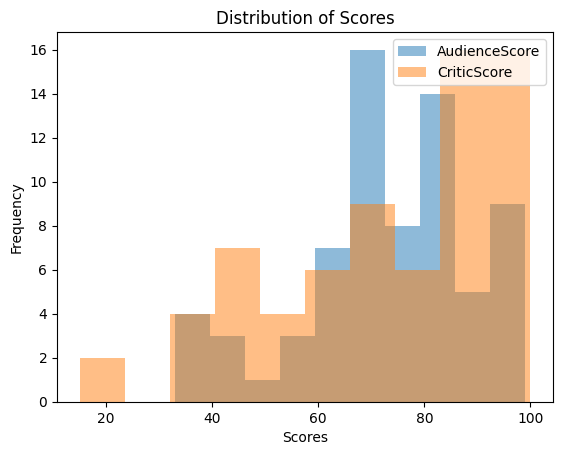

In [ ]:
import matplotlib.pyplot as plt

# Connect to db
conn = sqlite3.connect('movies_scores.db')
query = 'SELECT * FROM PredictedScores'
df = pd.read_sql_query(query, conn)

# Ensure data is numeric
df['AudienceScore'] = pd.to_numeric(df['AudienceScore'].str.rstrip('%'))
df['CriticScore'] = pd.to_numeric(df['CriticScore'].str.rstrip('%'))
df['PredictedScore'] = pd.to_numeric(df['PredictedScore'])

# Plot score distributions to assess skewness and decide if weighted loss functions are needed
plt.hist(df['AudienceScore'], bins=10, alpha=0.5, label='AudienceScore')
plt.hist(df['CriticScore'], bins=10, alpha=0.5, label='CriticScore')
plt.legend(loc='upper right')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()

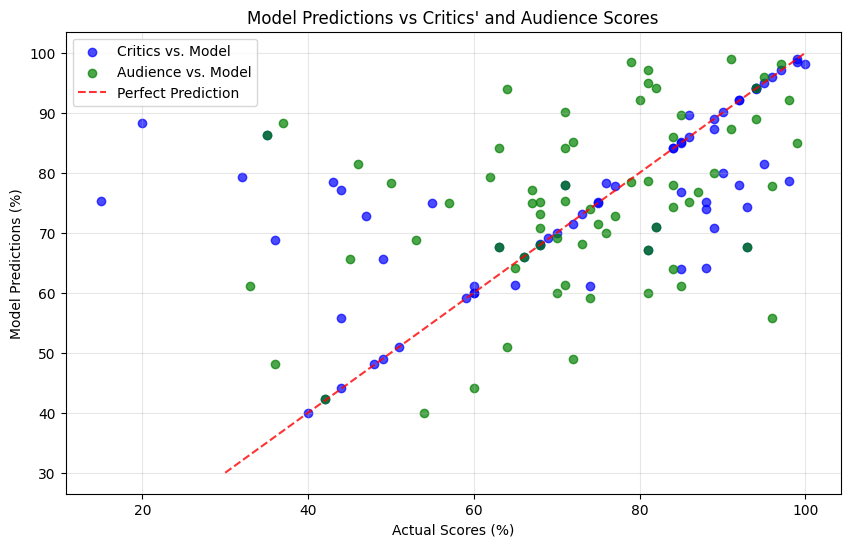

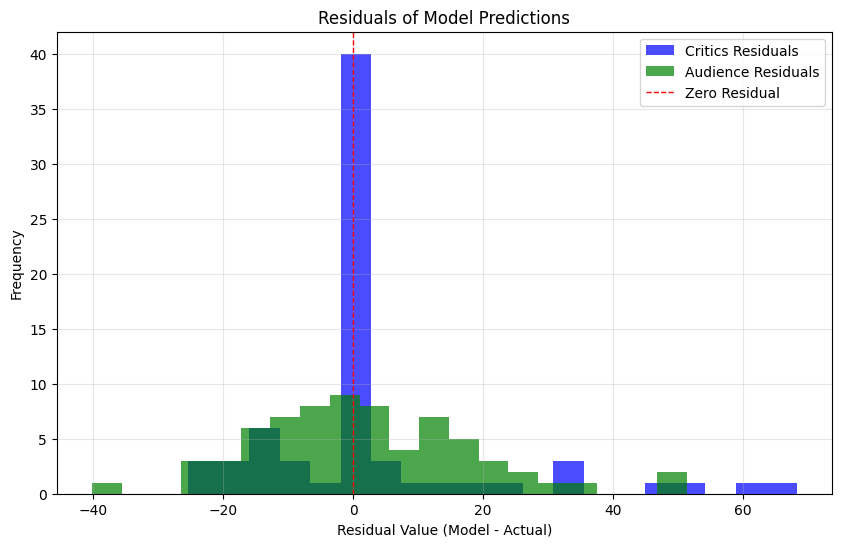

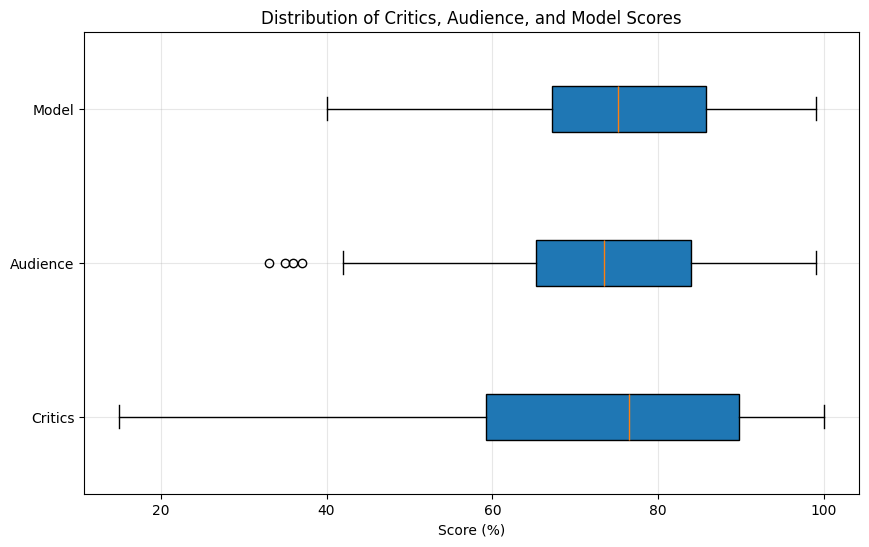

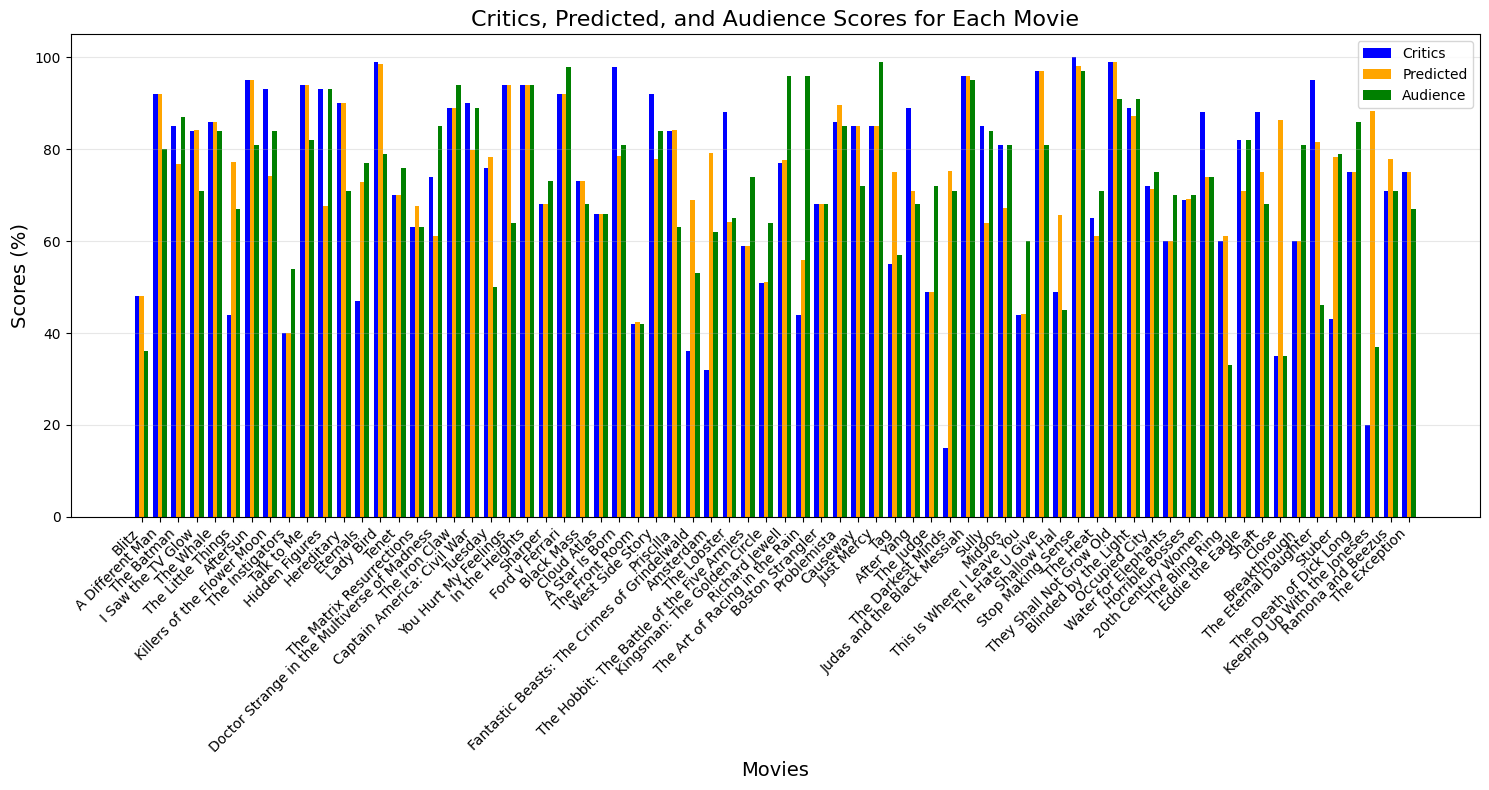

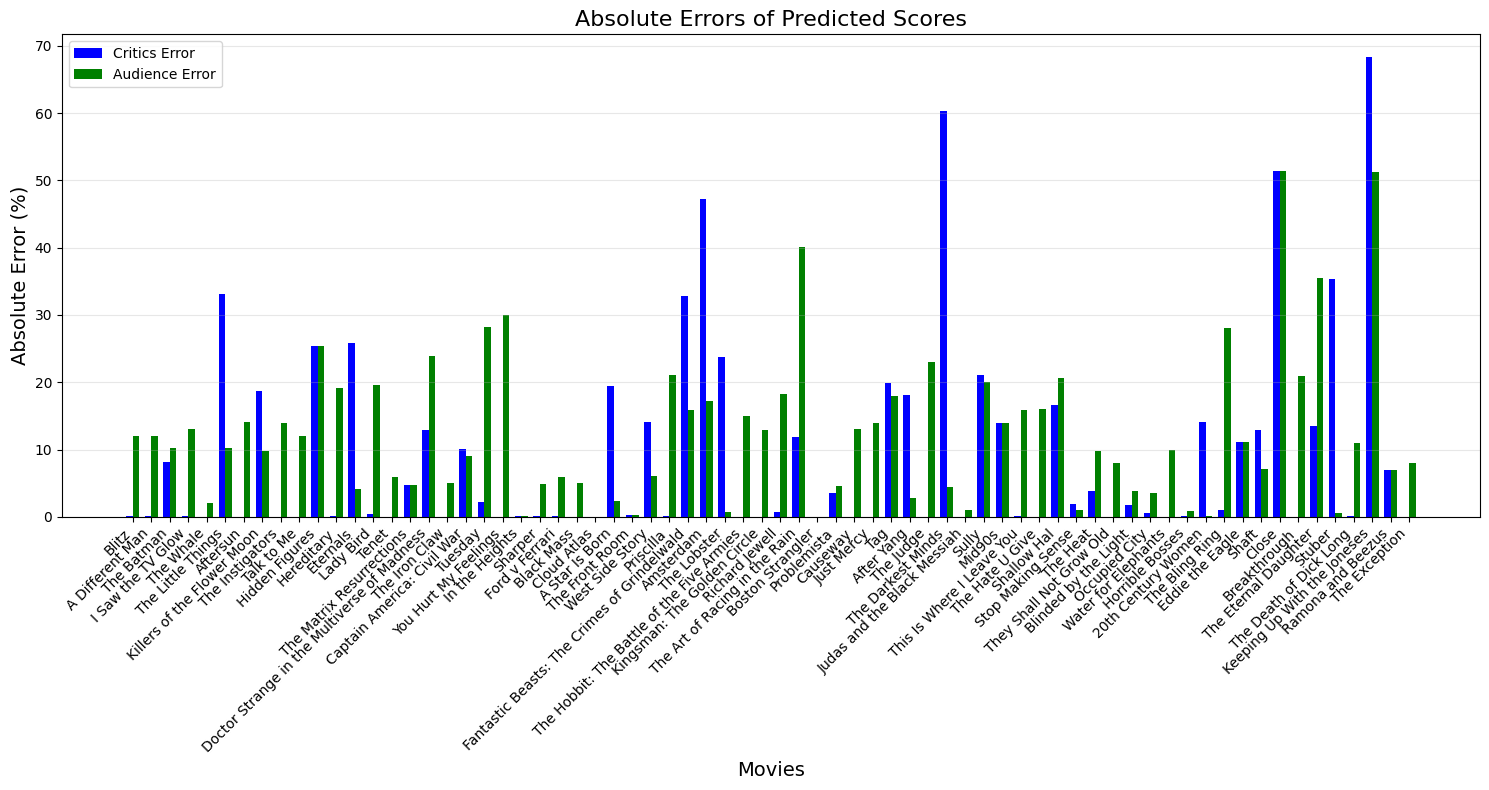

In [ ]:
# Visualization 1 - Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['CriticScore'], df['PredictedScore'], label='Critics vs. Model', alpha=0.7, color='blue')
plt.scatter(df['AudienceScore'], df['PredictedScore'], label='Audience vs. Model', alpha=0.7, color='green')
plt.plot([30, 100], [30, 100], 'r--', label='Perfect Prediction', alpha=0.8)
plt.title("Model Predictions vs Critics' and Audience Scores")
plt.xlabel("Actual Scores (%)")
plt.ylabel("Model Predictions (%)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Visualization 2 - Histogram of Residuals
plt.figure(figsize=(10, 6))
critics_residuals = df['PredictedScore'] - df['CriticScore']
audience_residuals = df['PredictedScore'] - df['AudienceScore']
plt.hist(critics_residuals, bins=20, alpha=0.7, label='Critics Residuals', color='blue')
plt.hist(audience_residuals, bins=20, alpha=0.7, label='Audience Residuals', color='green')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1, label='Zero Residual')
plt.title("Residuals of Model Predictions")
plt.xlabel("Residual Value (Model - Actual)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Visualization 3 - Boxplot
plt.figure(figsize=(10, 6))
boxplot_data = [df['CriticScore'], df['AudienceScore'], df['PredictedScore']]
plt.boxplot(boxplot_data, vert=False, patch_artist=True, labels=['Critics', 'Audience', 'Model'])
plt.title("Distribution of Critics, Audience, and Model Scores")
plt.xlabel("Score (%)")
plt.grid(alpha=0.3)
plt.show()

# Visualization 4 - Score Bar Chart
plt.figure(figsize=(15, 8))
bar_width = 0.25
indices = range(len(df))
plt.bar([i - bar_width for i in indices], df['CriticScore'], width=bar_width, label='Critics', color='blue')
plt.bar(indices, df['PredictedScore'], width=bar_width, label='Predicted', color='orange')
plt.bar([i + bar_width for i in indices], df['AudienceScore'], width=bar_width, label='Audience', color='green')
plt.title("Critics, Predicted, and Audience Scores for Each Movie", fontsize=16)
plt.xlabel("Movies", fontsize=14)
plt.ylabel("Scores (%)", fontsize=14)
plt.xticks(indices, df['Title'], rotation=45, ha='right')  # Movie titles on x-axis
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Visualization 5 - Error Bar Chart
plt.figure(figsize=(15, 8))
audience_error = abs(df['PredictedScore'] - df['AudienceScore'])
critic_error = abs(df['PredictedScore'] - df['CriticScore'])
bar_width = 0.35
indices = range(len(df))
plt.bar([i - bar_width/2 for i in indices], critic_error, width=bar_width, label='Critics Error', color='blue')
plt.bar([i + bar_width/2 for i in indices], audience_error, width=bar_width, label='Audience Error', color='green')
plt.title("Absolute Errors of Predicted Scores", fontsize=16)
plt.xlabel("Movies", fontsize=14)
plt.ylabel("Absolute Error (%)", fontsize=14)
plt.xticks(indices, df['Title'], rotation=45, ha='right')  # Movie titles on x-axis
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()